# Motion analysis for Totems

### Usage

Replace the values in the cell below with the data files you want to analyze.

In [568]:
# Parent directory of the data
input_dir = "data/b33e64f7-2065-4061-b300-180d96fb3f86"
# The file to analyze
target_dir = "PD_45_04"

# Time and Static reference files. This values usually don't change.
time_ref = "Reference Data/_time.txt"
static_ref = "Reference Data/_ref.txt"

In [569]:
%matplotlib inline
!pip install pyquaternion

In [570]:
import os
import sys
import json
import math
from glob import glob

import numpy as np
import scipy.optimize
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map
from matplotlib.colors import Normalize
import matplotlib 

mpl.rcParams['figure.figsize'] = (20, 14)

class Tools(object):
    
    @staticmethod
    def load(filename, ref_em=None, ref_gt=None):
        print("Loading {}".format(filename))
        input_data = np.loadtxt(filename, delimiter=", ", skiprows=1)

        frame_id = input_data[:, 0]
        em = input_data[:, 2:9]
        gt = input_data[:, 12:19]
        ts_em = input_data[:, 19]
        ts_gt = input_data[:, 20]

        first_frame_em = em[0,:]
        first_frame_gt = gt[0,:]
        norm_em = np.linalg.norm(em - (ref_em if ref_em is not None else first_frame_em), axis=1)
        norm_gt = np.linalg.norm(gt - (ref_gt if ref_gt is not None else first_frame_gt), axis=1)

        return frame_id, (em, ts_em, norm_em), (gt, ts_gt, norm_gt)

    @staticmethod
    def timeshift(a, b, delta=0):
        pad = np.zeros(abs(delta))
        if delta > 0:
            return a[delta:], b[:-delta]

        elif delta < 0:
            return a[:-delta], b[delta:]

        else: 
            return a, b
        
    @staticmethod  
    def scatter3d(x,y,z, cs, colorsMap='jet'):
        cmap = plt.get_cmap(colorsMap)
        cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
        scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
        scalarMap.set_array(cs)
        fig.colorbar(scalarMap)
        plt.show()

Loading data/b33e64f7-2065-4061-b300-180d96fb3f86/Reference Data/_time.txt


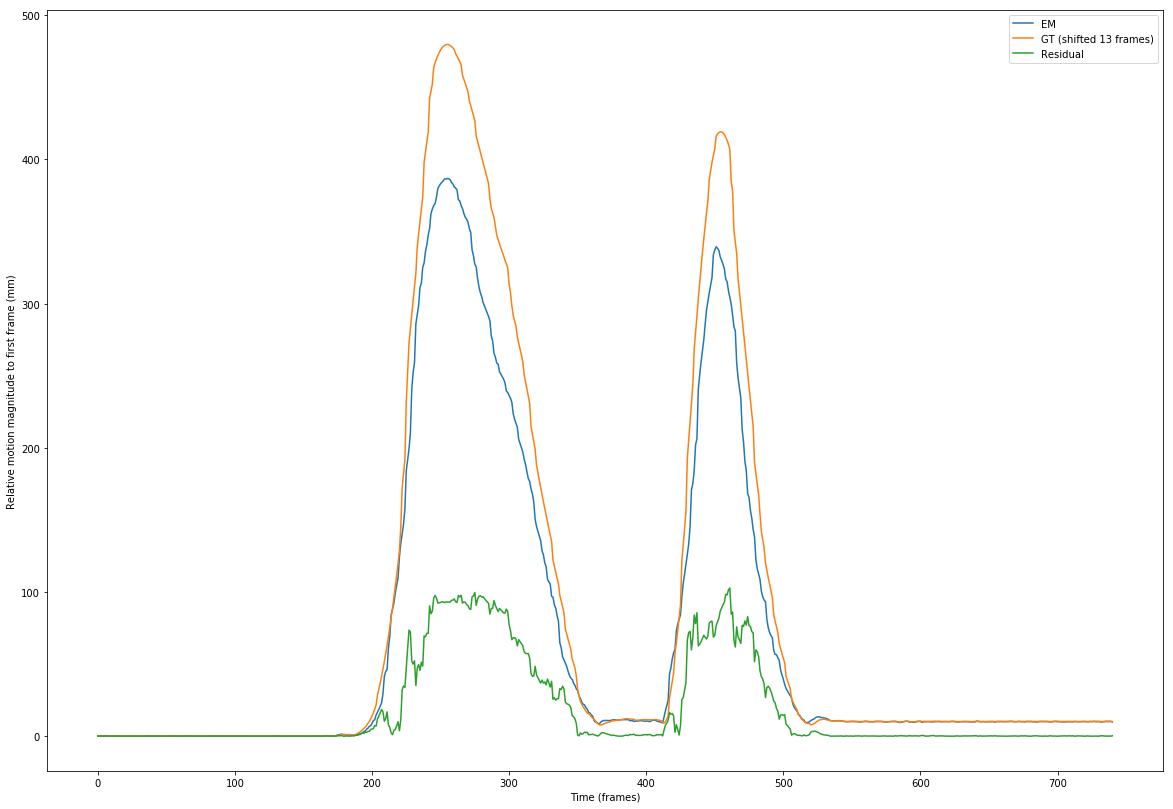

In [571]:
f1 = plt.figure(1)
frame_time_id, em, gt = Tools.load(os.path.join(input_dir, time_ref)) 
time_em, time_ts_em, time_norm_em = em
time_gt, time_ts_gt, time_norm_gt = gt

N = 30 # number of samples for rolling average. This smooths both signals before aligning them
time_norm_em_smooth = np.convolve(time_norm_em, np.ones((N,))/N, mode='valid')
time_norm_gt_smooth = np.convolve(time_norm_gt, np.ones((N,))/N, mode='valid')

delta = np.argmax(time_norm_em_smooth) - np.argmax(time_norm_gt_smooth)
time_norm_em, time_norm_gt = Tools.timeshift(time_norm_em, time_norm_gt, delta)

plt.plot(time_norm_em, label='EM') 
plt.plot(time_norm_gt, label='GT (shifted {} frames)'.format(delta))
plt.plot(np.abs(time_norm_gt - time_norm_em), label='Residual')
plt.xlabel('Time (frames)')
plt.ylabel('Relative motion magnitude to first frame (mm)')
plt.legend()

In [572]:

#
# DATA LOADING
#

# STATIC REF
with open(os.path.join(input_dir, static_ref)) as fin:
    # Read lines but skip header
    lines = [ 
        [
            float(token.strip())
            for token in line.split(',')
        ]
        for i, line in enumerate(fin) 
        if i > 0] 

ref = np.array(lines[0])
ref_em_avg = ref[2:9]
ref_gt_avg = ref[12:19]

glob_expr = os.path.join(input_dir, target_dir, "*.csv")
files = [
    f
    for f in glob(glob_expr)
    if not (f.endswith("_rt.csv") or f.endswith("_s_ml.csv") or f.endswith("_s_ot.csv"))
]

print("Using {}".format(files[0]))

# FRAME DATA
frame_dyn_id, em, gt = Tools.load(
    files[0], 
    ref_em=ref_em_avg, 
    ref_gt=ref_gt_avg)

dyn_em, dyn_ts_em, dyn_norm_em = em
dyn_gt, dyn_ts_gt, dyn_norm_gt = gt

dyn_em, dyn_gt = Tools.timeshift(dyn_em, dyn_gt, delta)
dyn_norm_em, dyn_norm_gt = Tools.timeshift(dyn_norm_em, dyn_norm_gt, delta)

dyn_residual = np.abs(dyn_norm_gt - dyn_norm_em)  

Using data/b33e64f7-2065-4061-b300-180d96fb3f86/PD_45_04/OT-EM_data_20171211_164521.csv
Loading data/b33e64f7-2065-4061-b300-180d96fb3f86/PD_45_04/OT-EM_data_20171211_164521.csv


10082 10082


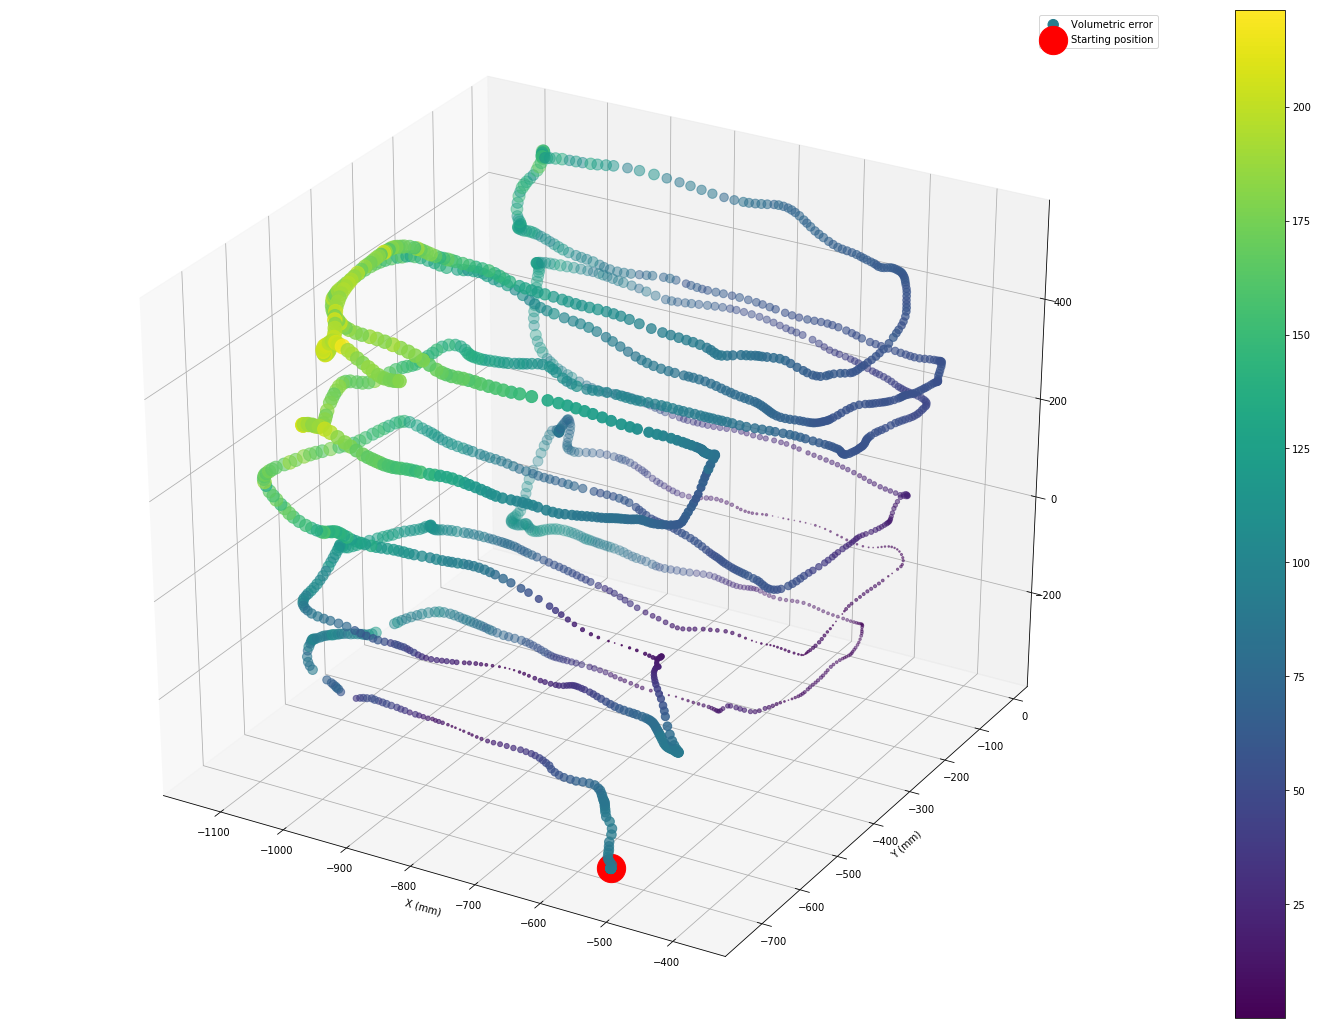

In [573]:
# We subsample the path by this rate.
step = 5


#
# 3D plot
# 

x = dyn_gt[:,0] * -1
y = dyn_gt[:,2]
z = dyn_gt[:,1]
cs = dyn_residual
s = dyn_residual

print(len(x), len(cs))

cmap = plt.get_cmap()
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cm.ScalarMappable(norm=cNorm)
c = scalarMap.to_rgba(cs)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x[::step], y[::step], z[::step], 
           c=c[::step], 
           s=s[::step],
           label='Volumetric error')

ax.scatter(x[0], y[0], z[0],
    color='r', 
    s=800,
    label='Starting position')

scalarMap.set_array(cs)
fig.colorbar(scalarMap) 

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
# plt.zlabel('Z (mm)')
plt.legend()

 


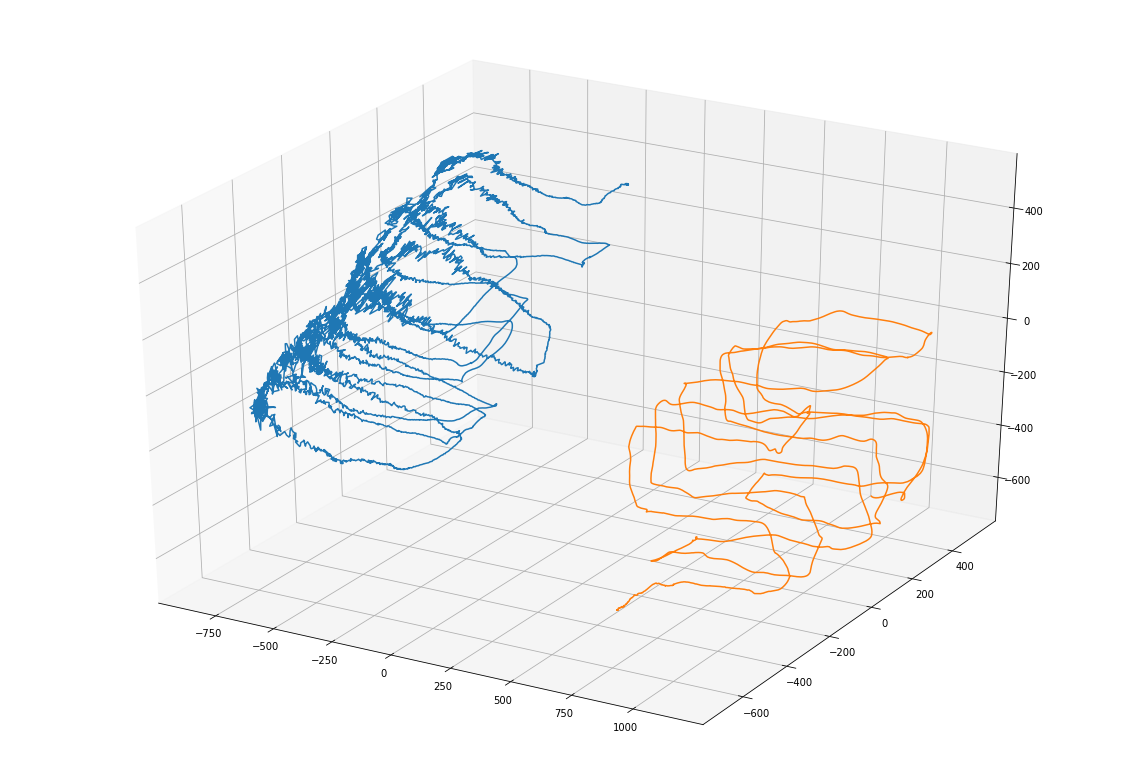

In [574]:
#
# 3D plot
# 
f5 = plt.figure(5) 
ax = f5.gca(projection='3d')


ax.plot(dyn_em[:,0], dyn_em[:,1], dyn_em[:,2], label='EM')
ax.plot(dyn_gt[:,0], dyn_gt[:,1], dyn_gt[:,2], label='GT')

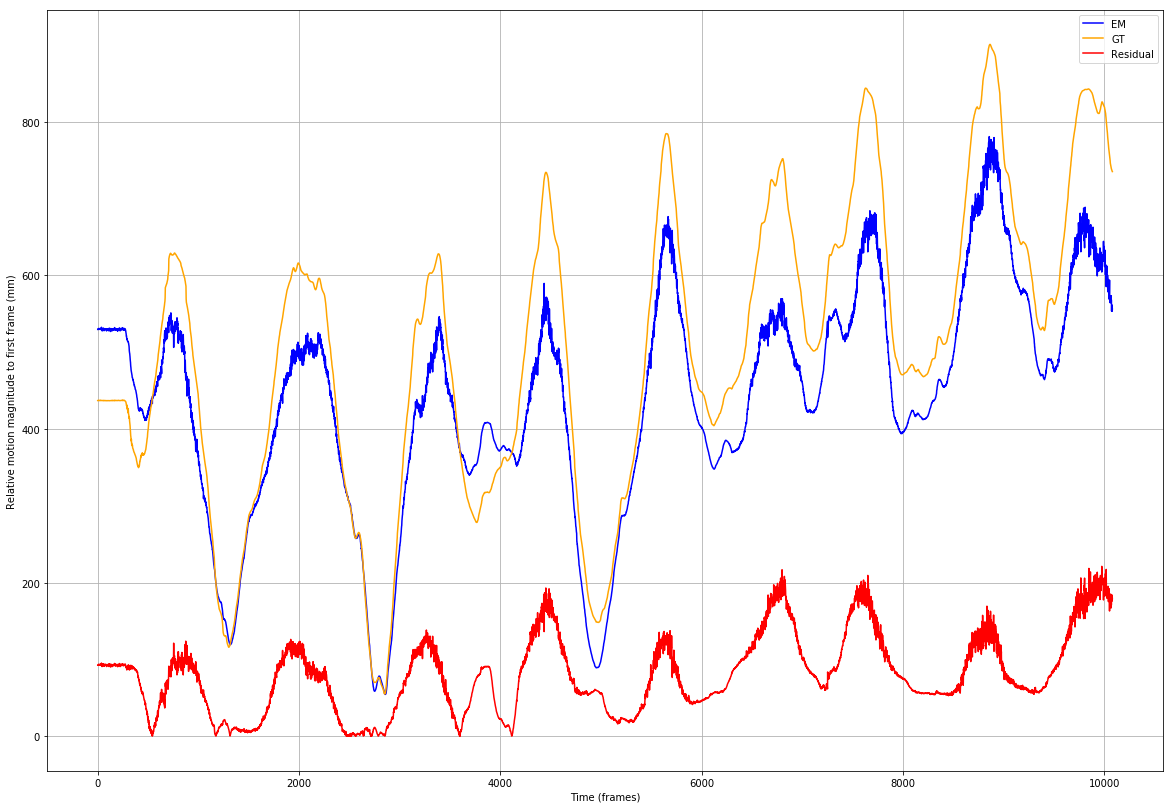

In [575]:
f2 = plt.figure(2)
plt.plot(dyn_norm_em, label='EM', color='blue')
plt.plot(dyn_norm_gt, label='GT', color='orange')
plt.plot(dyn_residual, label='Residual', color='red')
plt.xlabel('Time (frames)')
plt.ylabel('Relative motion magnitude to first frame (mm)')
plt.legend()
plt.grid()
# f2.show()

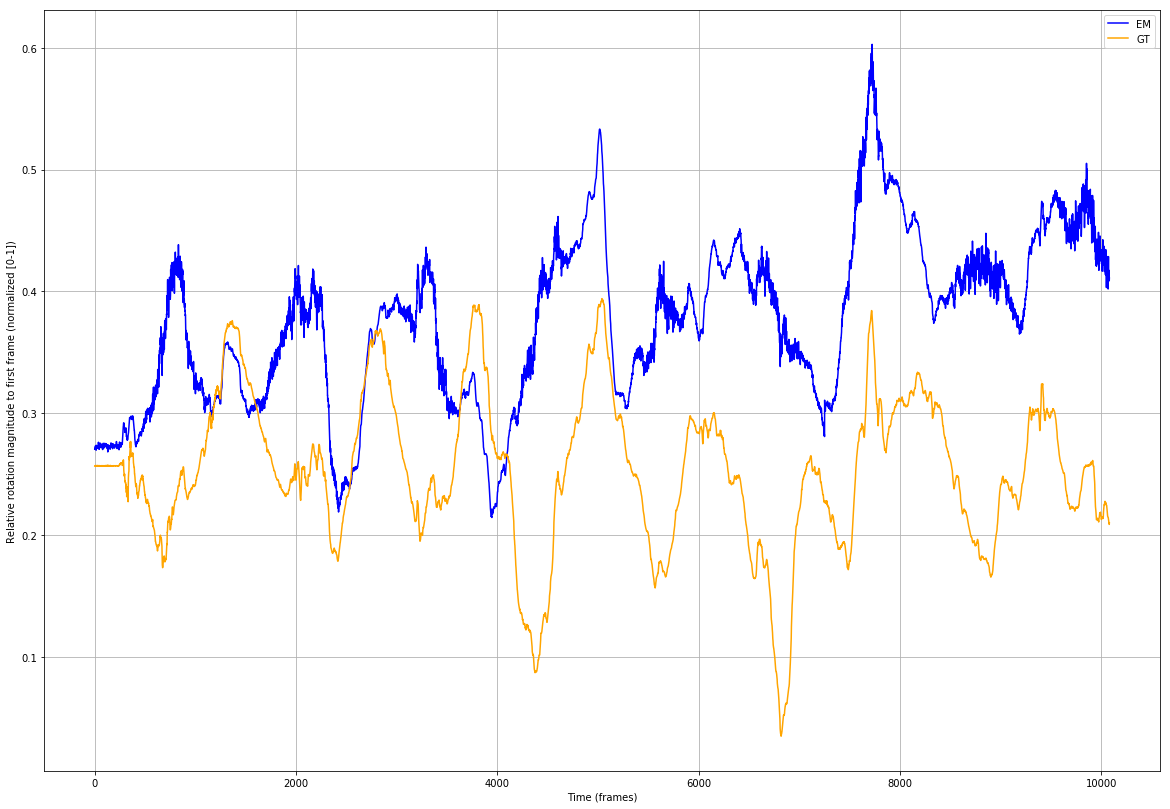

In [576]:
from pyquaternion import Quaternion

# The maximum rotation distance
max_rot_val = Quaternion.absolute_distance(
    Quaternion(axis=[1.0, 0.0, 0.0], degrees=0), 
    Quaternion(axis=[1.0, 0.0, 0.0], degrees=180))

def q_distance(ref, samples):
    q_ref = Quaternion(ref).unit
    return np.array([
        Quaternion.absolute_distance(
            q_ref, 
            Quaternion(sample).unit
        )
        for sample in samples
    ])
        
rot_dist_em = (q_distance(ref_em_avg[3:8], dyn_em[:, 3:8]) / max_rot_val)
rot_dist_gt = (q_distance(ref_gt_avg[3:8], dyn_gt[:, 3:8]) / max_rot_val)

rot_dist_residual = rot_dist_em - rot_dist_gt

f4 = plt.figure(4)
plt.plot(rot_dist_em, label='EM', color='blue')
plt.plot(rot_dist_gt, label='GT', color='orange')
# plt.plot(rot_dist_residual, label='Residual', color='red')  # Not plotting residual since it's too big
plt.xlabel('Time (frames)')
plt.ylabel('Relative rotation magnitude to first frame (normalized [0-1])')
plt.legend()
plt.grid()




## End of report

Experimental features below.

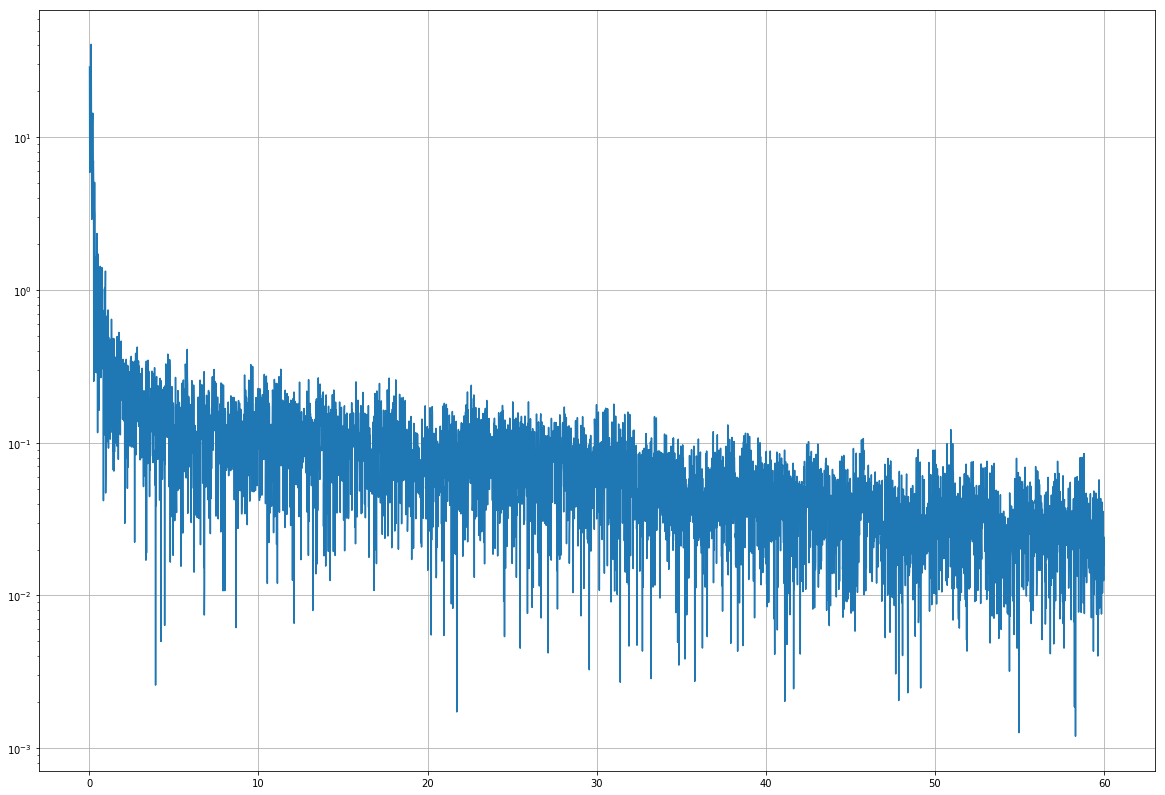

In [577]:
from scipy.fftpack import fft


# sample spacing
T = 1.0 / 120.0
N_samples = len(dyn_residual)
x = np.arange(N_samples) 
yf = fft(dyn_residual)
xf = np.linspace(0.0, 1.0/(2.0*T), N_samples//2)
plt.semilogy(xf[1:], 2.0/N_samples * np.abs(yf[0:N_samples//2])[1:])
plt.grid()
plt.show()